# Introduction to Adaptive Thresholding
This tutorial will go over some basic concepts you may wish to consider when setting thresholds for production models or otherwise.

## Make Some Data
This tutorial doesn't actually require real data--nor even a model! We'll make some fake data to get the idea. Don't worry too much about this step. Let's just assume we have a series of scores. These could represent model performance, divergences, or model scores themselves. Throughout this tutorial, we'll assume that increasing values of this score will be increasingly likely to represent a good alert. Then we are left to determine an appropriate threshold to balance true/false positive/negatives. This is balancing time wasted on bad alerts with the utility gained from finding a good alert that resulted from a lower score.

In [1]:
import numpy
import pandas

numpy.random.seed(0)
pandas.options.display.max_rows=5 # restrict to 5 rows on display

n_positive = 600
positives = numpy.random.beta(5, 1, size=n_positive)
n_negative = 5 * n_positive
negatives = numpy.random.beta(2, 3, size=n_negative)
data = pandas.DataFrame(numpy.asarray((numpy.concatenate((numpy.ones(n_positive),
                                                          numpy.zeros(n_negative))),
                                       numpy.concatenate((positives,
                                                          negatives)))).T,
                        columns=['Ground Truth', 'Model Score'])
data = data.sample(frac=1, random_state=0).reset_index(drop=True)
data

,Ground Truth,Model Score
0,0.0,0.677909
1,0.0,0.327262
...,...,...
3598,0.0,0.185715
3599,0.0,0.113929


## Positive and Negative Distributions

We want to determine the trade off between catching more true positives and getting more false negatives. Let's see what the distribution of scores associated with good (positive) and bad (negative) alerts looks like.

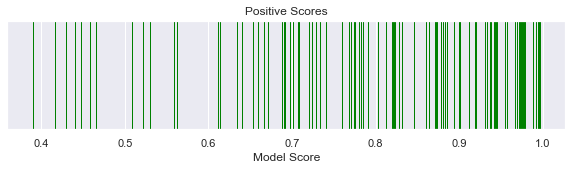

In [2]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pylab as plt
import numpy

plt.figure(figsize=(10, 2))

plt.title('Positive Scores')
plt.xlabel('Model Score')
plt.yticks([])
positives = data[data['Ground Truth'] == 1]['Model Score'].sample(100, random_state=0).values
sns.rugplot(positives,
            height=1.0,
            color='green',
            label='Positive Samples')
plt.show()

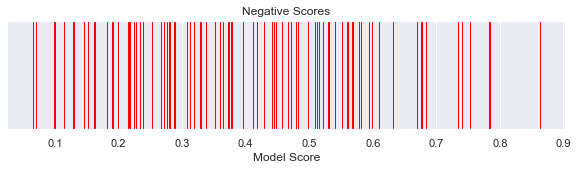

In [3]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pylab as plt
import numpy

plt.figure(figsize=(10, 2))

plt.title('Negative Scores')
plt.xlabel('Model Score')
plt.yticks([])
negatives = data[data['Ground Truth'] == 0]['Model Score'].sample(100, random_state=0).values
sns.rugplot(negatives,
            height=1.0,
            color='red',
            label='Negative Samples')
plt.show()

We can also plot an approximation of the probability distribution of positive and negative scores given our sample data.

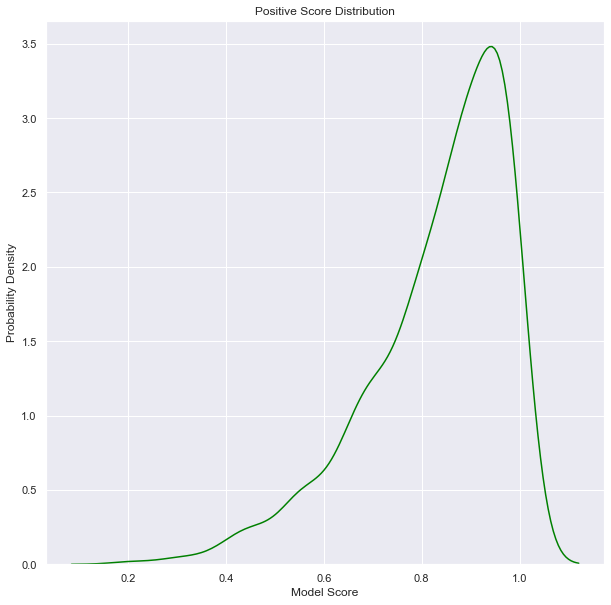

In [4]:
plt.figure(figsize=(10, 10))

sns.set()
plt.title('Positive Score Distribution')
plt.xlabel('Model Score')
plt.ylabel('Probability Density')
positives = data[data['Ground Truth'] == 1]['Model Score'].values
sns.kdeplot(positives,
            color='green',
            label='Positive Score Distribution')
plt.show()

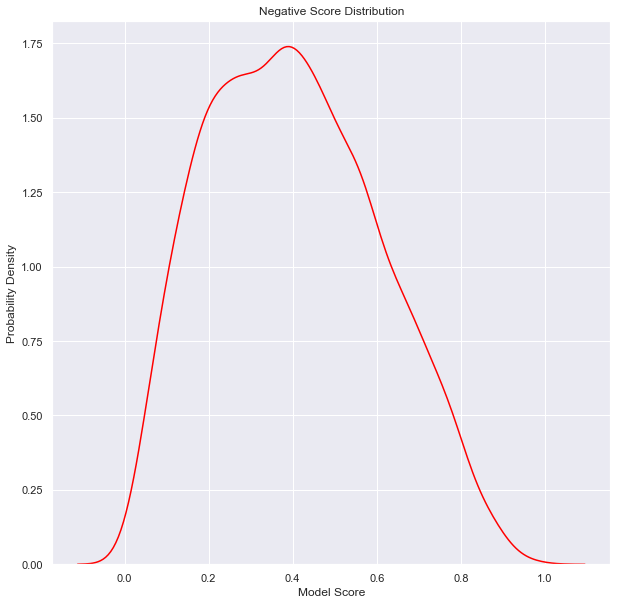

In [5]:
plt.figure(figsize=(10, 10))

sns.set()
plt.title('Negative Score Distribution')
plt.xlabel('Model Score')
plt.ylabel('Probability Density')
negatives = data[data['Ground Truth'] == 0]['Model Score'].values
sns.kdeplot(negatives,
            color='red',
            label='Negative Score Distribution')
plt.show()

It will also be important to keep in mind the distribution of model scores.

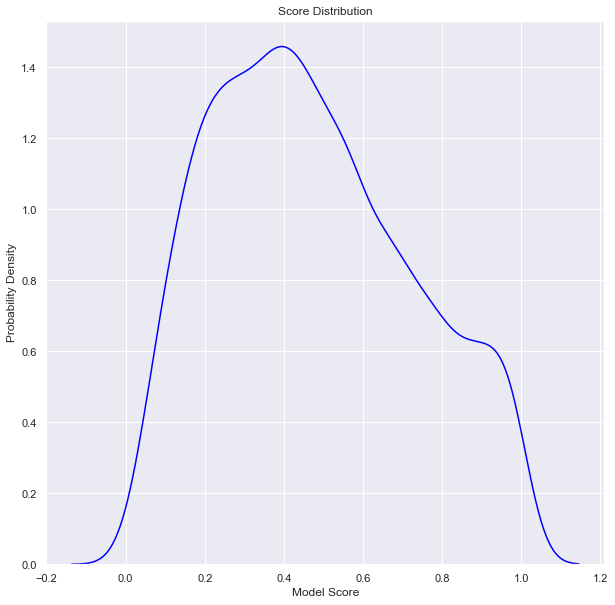

In [6]:
plt.figure(figsize=(10, 10))

sns.set()
plt.title('Score Distribution')
plt.xlabel('Model Score')
plt.ylabel('Probability Density')
scores = data['Model Score'].values
sns.kdeplot(scores,
            color='blue',
            label='Score Distribution')
plt.show()

## Computing Optimal Thresholds
When scoring a model after choosing a threshold, each model score can be associated with one of four possible outcomes:

1. Positive instance is scored above the threshold.
2. Negative instance is scored above the threshold.
3. Negative instance is scored at or below the threshold.
4. Positive instance is scored at or below the threshold.

Let's say each of these outcomes has an associated probability $p$ and an associated utility $u$ as determined by the business:

1. $p_\mathrm{tp}$, $u_\mathrm{tp}$
2. $p_\mathrm{fp}$, $u_\mathrm{fp}$
3. $p_\mathrm{tn}$, $u_\mathrm{tn}$
4. $p_\mathrm{fn}$, $u_\mathrm{fn}$

Then the expected utility of a scored sample with unknown ground truth is

$u = p_\mathrm{tp}u_\mathrm{tp} +
p_\mathrm{fp}u_\mathrm{fp} +
p_\mathrm{tn}u_\mathrm{tn} +
p_\mathrm{fn}u_\mathrm{fn}$

For the purposes of this experiment, let's say the business would be 10 times as disappointed to learn of a false negative than they would be to have to pay for analysts wasting their time on a false positive.

In [7]:
def utility(tp, fp, tn, fn):
    return -10 * fn - fp

## Visualizing Utility of Each Threshold
Let's plot expected utility against some candidate thresholds. The algorithm below will generate a plot with error bars over the expected value. If you need to interpret them, you can say _there's a 50% chance the true utility of each threshold falls within the shaded region_.

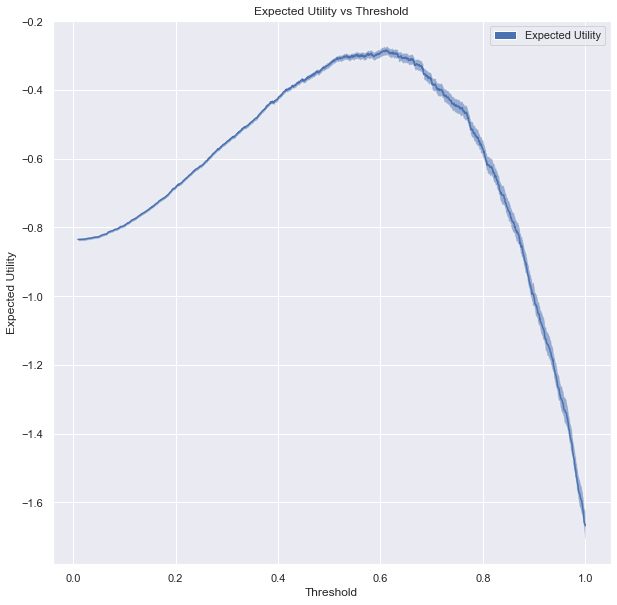

In [8]:
import numpy
import matplotlib.pylab as plt
import seaborn as sns, numpy

from mvtk import thresholding

plt.figure(figsize=(10, 10))
plt.title('Expected Utility vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Expected Utility')

scores, utility_mean, utility_quantiles = thresholding.expected_utility(
    utility, data[['Ground Truth', 'Model Score']].values)
thresholding.plot_err(scores,
         utility_mean,
         utility_quantiles,
         label='Expected Utility')
leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

## Finding the Optimal Threshold

This is the threshold that corresponds to the peak of the utility function plotted above.

You don't need to worry about the mechanics of this function, you can just copy and paste it.

In [9]:
thresholding.optimal_threshold(utility, data)

(0.6114780190088583, -0.2845361056272087)

## Optimal Threshold Distribution
If we know our sample of positives and negatives is unbiased (e.g. the analysts were equally likely to label any instance of their data), we can generally express our uncertainty in the location of the optimal threshold (which stems from our uncertainty in the utility function) to compute a distribution over what our optimum threshold might be given the data we have so far.

You don't need to worry about the mechanics of this function, you can just copy and paste it.

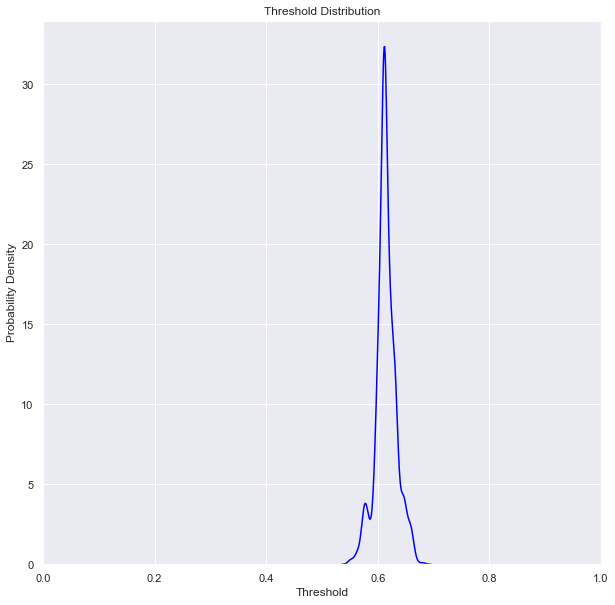

In [10]:
sns.set(); numpy.random.seed(0)
plt.figure(figsize=(10, 10))
plt.xlim([0, 1])
plt.title('Threshold Distribution')
plt.xlabel('Threshold')
plt.ylabel('Probability Density')
sns.kdeplot(thresholding.thompson_sample(utility, data),
             color='blue',
             label='Likelihood Threshold is Optimal')
plt.show()

## Adaptive Thresholding
Without getting into the mechanics, we can dynamically choose between _exploration mode_, during which it will set the threshold to `0`, and _exploitation mode_, during which it will attempt to pick the optimal choice (or, in practice, something likely to be optimal).

## Online Learning
Here we will give an example of how to apply adaptive thresholding to an online learning problem. 

In this example, we will iterate over the data we have in chronological order (since it's fake data, let's just assume it was already ordered chronologically) and simulate a system that applies the above adaptive thresholding algorithm to the problem of identifying a new optimal threshold each time a new label arrives (e.g. from someone checking in on an alert and determining if it's a good one).

In [11]:
thresholder = thresholding.AdaptiveThreshold(utility)
thresholds = []
for ground_truth, score in data[['Ground Truth', 'Model Score']].values:
    thresholds.append(thresholder(ground_truth, score))
thresholds = numpy.asarray(thresholds)

What percent of the time did we end up setting the threshold to `0`? You'll notice we start out setting the threshold to `0` about 45% of the time to gather data, but that quickly drops to about 5% once we have a good understanding of the system.

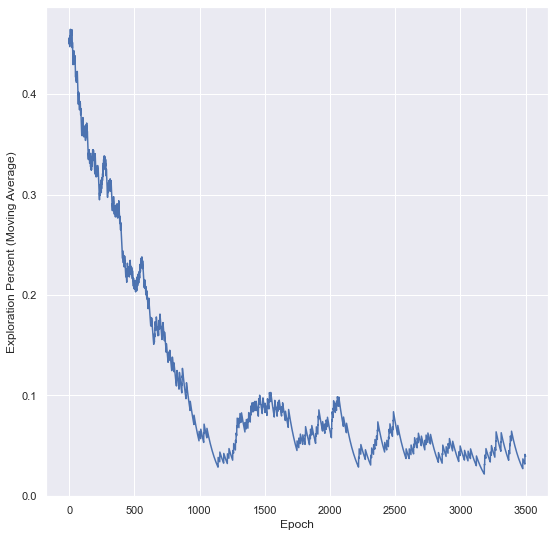

In [12]:
import matplotlib.pylab as plt

plt.figure(figsize=(9, 9))
plt.ylabel('Exploration Percent (Moving Average)')
plt.xlabel('Epoch')
plt.plot(thresholding.exploration_proportion(thresholds, 100))
plt.show()

About 10% of the alerts triggered were just to get unbiased data.

In [13]:
(thresholds == 0).sum()

379

In [14]:
(thresholds == 0).mean()

0.10527777777777778

## Examining Results
To get a feel for what the algorithm is doing, let's reconstruct the utility function plot as before, but with the 64 most recent thresholds. As you can see, the thresholds are landing pretty close to the optimal value, while we were typically only taking unbiased data 2 to 3% of the time.

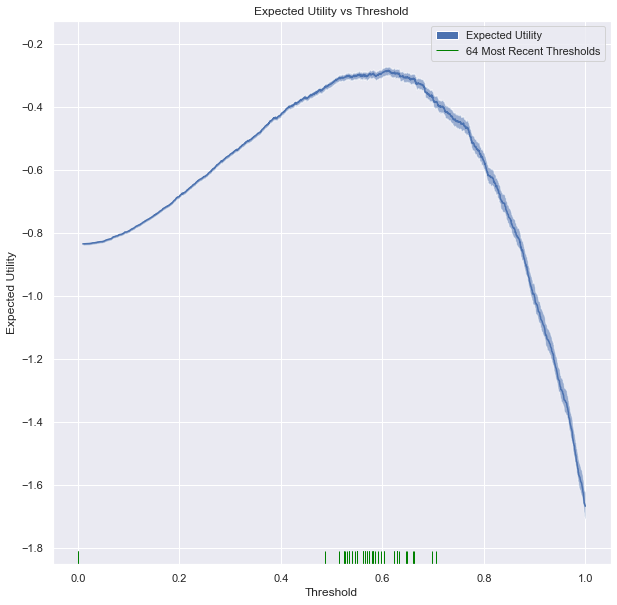

In [15]:
import matplotlib.pylab as plt
import seaborn as sns, numpy

plt.figure(figsize=(10, 10))
plt.title('Expected Utility vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Expected Utility')

scores, utility_mean, utility_quantiles = thresholding.expected_utility(
    utility, data[['Ground Truth', 'Model Score']].values)

# candidate thresholds are existing model scores
thresholding.plot_err(scores,
         utility_mean,
         utility_quantiles,
         label='Expected Utility')
ax = sns.rugplot(thresholds[-64:], # most recent 
                  color='green',
                  label='64 Most Recent Thresholds')
leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

We can watch the distribution of (nonzero) thresholds chosen evolve over time and approach the ideal one (computed using _all_ the data in our data set).

In [16]:
%%capture

import matplotlib.pylab as plt
import seaborn as sns, numpy
import os
import shutil

from pathlib import Path

frame_dir = 'frames'
if os.path.exists(frame_dir):
    shutil.rmtree(frame_dir)
Path(frame_dir).mkdir(parents=True, exist_ok=True)


def mkplot(thresholds, large_sample_ideal_thresholds):
    sns.set(); numpy.random.seed(0)
    plt.figure(figsize=(10, 10))
    plt.xlim([0, 1])
    plt.title(f'Threshold Distribution (epoch {i})')
    plt.xlabel('Threshold')
    plt.ylabel('Probability Density')
    ax = sns.distplot(thresholds[thresholds > 0],
                      rug=True,
                      hist=False,
                      kde=True,
                      color='green',
                      label='Thresholds Chosen Using Unbiased Samples')
    ax = sns.distplot(large_sample_ideal_thresholds, # most recent 
                      rug=False,
                      hist=False,
                      kde=True,
                      color='blue',
                      label='Ideal Threshold Distribution')
    leg = plt.legend(loc='upper right')
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    plt.savefig(os.path.join(frame_dir, f'im_{i}.png'))
    
large_sample_ideal_thresholds = thresholding.thompson_sample(utility, data)
N = 64
dn = len(thresholds) // N
j = 0
for num_frames, i in enumerate(range(dn, len(thresholds) + dn, dn)):
    mkplot(thresholds[j:i], large_sample_ideal_thresholds)
    j = i
mkplot(thresholds[j:], large_sample_ideal_thresholds)

In [19]:
import os
import imageio

images = []
for filename in sorted(os.listdir(frame_dir), key=lambda x: int(x[3:-4])):
    images.append(imageio.imread(os.path.join(frame_dir, filename)))
imageio.mimsave('threshold_distribution_evolution.gif', images,  duration=30 / (num_frames + 1))

![threshold_distribution_evolution](threshold_distribution_evolution.gif)